In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
import keras_tuner as kt

Input data and check for missing values. Since a lot of ages are missing, we will try to impute age numbers by seeing if there is any correlation with other features.

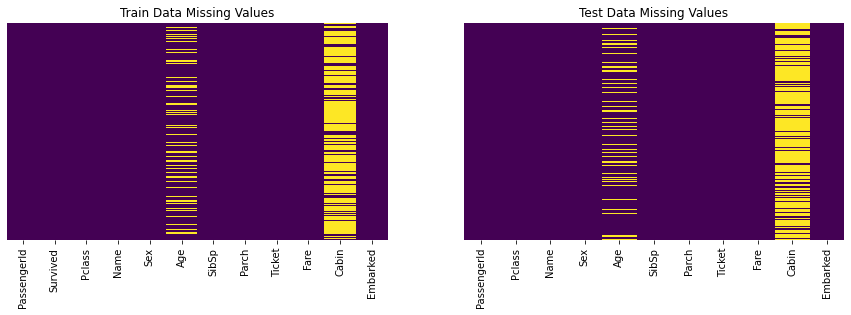

<Figure size 432x288 with 0 Axes>

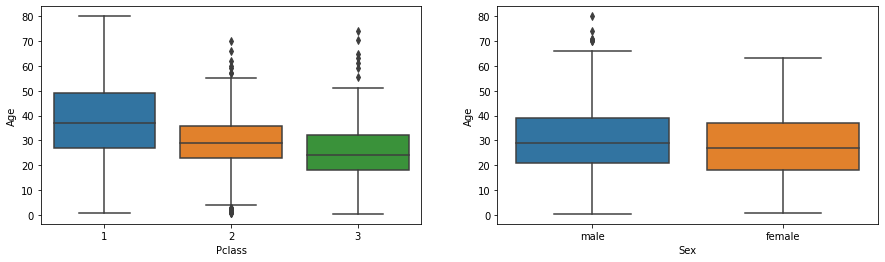

<Figure size 432x288 with 0 Axes>

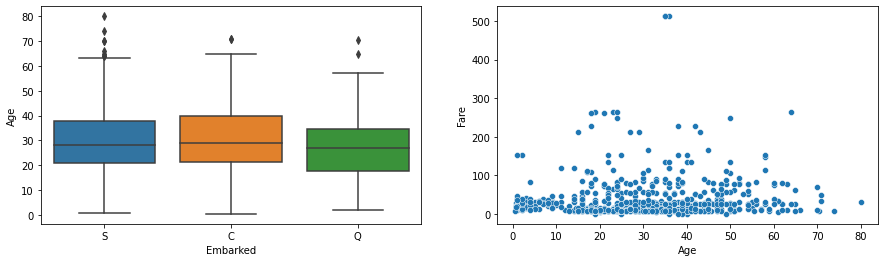

<Figure size 432x288 with 0 Axes>

In [9]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
sns.heatmap(train_data.isna(), cmap='viridis', yticklabels=False, cbar=False, ax=ax1).set(title='Train Data Missing Values')
sns.heatmap(test_data.isna(), cmap='viridis', yticklabels=False, cbar=False, ax=ax2).set(title='Test Data Missing Values')
plt.show()
plt.clf()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
sns.boxplot(x = "Pclass", y = "Age", data=train_data, ax=ax1)
sns.boxplot(x = "Sex", y = "Age", data=train_data, ax=ax2)
plt.show()
plt.clf()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
sns.boxplot(x = "Embarked", y = "Age", data=train_data, ax=ax1)
sns.scatterplot(x = "Age", y = "Fare", data=train_data, ax=ax2)
plt.show()
plt.clf()

Looks like only Pclass has a slight correlation with age, so we are going to define the imputation function by Pclass.
We'll find out the mean for each class first.

In [10]:
imputing = train_data[["Age", "Pclass"]]    
mean_age = imputing.groupby(["Pclass"]).mean().round()
print(mean_age)

         Age
Pclass      
1       38.0
2       30.0
3       25.0


Now we can define the imputation function.

In [11]:
def impute_age(cols):
    age = cols[0]
    Pclass = cols[1]
    if pd.isna(age):
        if Pclass == 1:
            return 38
        elif Pclass == 2:
            return 30
        else:
            return 25
    else:
        return age


Next, we will impute the age values using the function.
Notes: Finish Neural Network with Keras Tuner and use KFold Cross Validation, then continue to other machine learning models in SKLearn and use hyperparameter tuning for each model using GridSearchCV.

In [12]:
train_data["Age"] = imputing.apply(impute_age, axis = 1)
test_data["Age"] = test_data[["Age", "Pclass"]].apply(impute_age, axis = 1)

Then we can transform and use simple imputer from Scikit-Learn to impute any other values that are missing using pipelines.
We will use features with either numerical values or small number of selections in case it's categorical for now.
We are going to use One Hot Encoding to transform the categorical variables.

In [13]:
X = train_data.copy()
y = X.pop("Survived")

features_num = ["Pclass", "SibSp", "Parch", "Age", "Fare"]
features_cat = ["Sex", "Embarked"]

transformer_num = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)
transformer_cat = make_pipeline(
    OneHotEncoder(handle_unknown="ignore")
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)
X = preprocessor.fit_transform(X)
test_data = preprocessor.transform(test_data)

print(X.shape)

(891, 11)


We will define the neural network model using Keras and KerasTuner for Hyperparameter Tuning.
Hyperparameter tuning is used to define the optimum parameters such as number of layers, number of neurons per layer and dropout rate and the learning rate of the model.

In [36]:
input_shape = [11]
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.BatchNormalization(input_shape=input_shape))
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=hp.Int('units_'+str(i), min_value=32, max_value=512, step=32), activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(rate=hp.Float('rate'+str(i), min_value=0.1, max_value=0.6)))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='binary_crossentropy',
        metrics=['binary_accuracy'])
    return model

tuner = kt.RandomSearch(build_model, objective='binary_accuracy', max_trials=10, executions_per_trial=3,
 directory='project', project_name='titanic_prediction')


INFO:tensorflow:Reloading Oracle from existing project project\titanic_prediction\oracle.json
INFO:tensorflow:Reloading Tuner from project\titanic_prediction\tuner0.json


Search for the best hyperparameter using train test split.

In [37]:
hypX_train, hypX_test, hypy_train, hypy_test = train_test_split(X, y)
tuner.search(hypX_train, hypy_train, epochs = 5, validation_data = (hypX_test, hypy_test))

Trial 10 Complete [00h 00m 08s]
binary_accuracy: 0.7984032034873962

Best binary_accuracy So Far: 0.7984032034873962
Total elapsed time: 00h 00m 48s
INFO:tensorflow:Oracle triggered exit


Using KFold, we are going to do cross validation to find the accuracy of the model.

We can see the results of tuning with results_summary and extract the best parameters using get_best_hyperparameters.

In [38]:
tuner.results_summary()

Results summary
Results in project\titanic_prediction
Showing 10 best trials
Objective(name='binary_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 5
units_0: 160
rate0: 0.319342167666429
units_1: 480
rate1: 0.3228627663720839
learning_rate: 0.01
units_2: 512
rate2: 0.4939494972347793
units_3: 448
rate3: 0.12536639511698042
units_4: 416
rate4: 0.15456279106250467
units_5: 64
rate5: 0.5925352033696343
units_6: 224
rate6: 0.24742216000061448
units_7: 256
rate7: 0.3961697446187007
units_8: 288
rate8: 0.5611450915676766
units_9: 32
rate9: 0.17647048244162358
Score: 0.7984032034873962
Trial summary
Hyperparameters:
num_layers: 9
units_0: 352
rate0: 0.49500509107665536
units_1: 128
rate1: 0.3643011104589674
learning_rate: 0.01
units_2: 192
rate2: 0.506994724778041
units_3: 224
rate3: 0.16464151709238614
units_4: 224
rate4: 0.5790301273503792
units_5: 256
rate5: 0.44529399747324494
units_6: 384
rate6: 0.4267627092224031
units_7: 96
rate7: 0.11621440476920128
units_8: 41

In [43]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp)
model = build_model(best_hp)

In [45]:
kf = KFold(n_splits=5, random_state=None)

accuracy_scores = []

for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

    history = model.fit(
        X_train, y_train,
        batch_size = 512,
        epochs=100,
        verbose=0
    )

    scores = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(scores[1])

print(sum(accuracy_scores)/5)

0.8272424817085267
